# Import Necessary Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt

# Deep learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Image processing
import cv2

# File and directory handling
import os
import glob as gb


# Set Image Dataset Paths

In [2]:
# Define base directory
base_dir = 'D:/7.10.2024/archive (28)'

# Define paths for training, testing, and prediction datasets
data_paths = {
    'train': os.path.join(base_dir, 'seg_train', 'seg_train'),
    'test': os.path.join(base_dir, 'seg_test', 'seg_test'),
    'predict': os.path.join(base_dir, 'seg_pred', 'seg_pred')
}

# Accessing paths
trainpath = data_paths['train']
testpath = data_paths['test']
predpath = data_paths['predict']


In [3]:
# Define image processing constants
config = {
    'IMAGE_SIZE': (228, 228),
    'BATCH_SIZE': 32
}

# Accessing constants
IMAGE_SIZE = config['IMAGE_SIZE']
BATCH_SIZE = config['BATCH_SIZE']


# Load Training and Testing Datasets

In [4]:
def create_image_dataset(directory, image_size, batch_size, seed=None):
    """
    Creates a TensorFlow image dataset from the specified directory.

    Args:
        directory (str): Path to the directory containing images.
        image_size (tuple): Target size for the images.
        batch_size (int): Number of images to include in each batch.
        seed (int, optional): Random seed for shuffling.

    Returns:
        tf.data.Dataset: A TensorFlow dataset containing the images and labels.
    """
    return tf.keras.utils.image_dataset_from_directory(
        directory,
        seed=seed,
        image_size=image_size,
        batch_size=batch_size
    )

# Creating the training dataset
train_ds = create_image_dataset(trainpath, IMAGE_SIZE, BATCH_SIZE, seed=123)


Found 14034 files belonging to 6 classes.


In [5]:
def load_image_dataset(directory, image_size, batch_size, seed=None):
    """
    Load an image dataset from the specified directory.

    Args:
        directory (str): Path to the dataset directory.
        image_size (tuple): Target size of the images.
        batch_size (int): Number of images to load in each batch.
        seed (int, optional): Random seed for shuffling.

    Returns:
        tf.data.Dataset: A TensorFlow dataset containing the images and labels.
    """
    return tf.keras.utils.image_dataset_from_directory(
        directory,
        seed=seed,
        image_size=image_size,
        batch_size=batch_size
    )

# Load the test dataset using the function
test_ds = load_image_dataset(testpath, IMAGE_SIZE, BATCH_SIZE, seed=123)


Found 3000 files belonging to 6 classes.


In [6]:
def print_class_names(dataset):
    """
    Print the class names from the given dataset.

    Args:
        dataset (tf.data.Dataset): The dataset from which to extract class names.
    """
    class_names = dataset.class_names
    print("Class Names:")
    for index, name in enumerate(class_names):
        print(f"{index + 1}: {name.title()}")

# Call the function to print class names
print_class_names(train_ds)


Class Names:
1: Buildings
2: Forest
3: Glacier
4: Mountain
5: Sea
6: Street


# Get Image Paths for Prediction Dataset

In [7]:
def get_image_paths(path):
    """
    Retrieve all image paths from the specified directory.

    Args:
        path (str): The directory path to search for images.

    Returns:
        list: A list of full image paths.
    """
    return [os.path.join(dirname, filename) 
            for dirname, _, filenames in os.walk(path) 
            for filename in filenames]

# Get image paths from the prediction directory
images_paths = get_image_paths(predpath)

# Print the number of image paths found
print(f"Number of images found: {len(images_paths)}")


Number of images found: 7301


# Visualize Sample Training Images

Found 14034 files belonging to 6 classes.
Class Names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


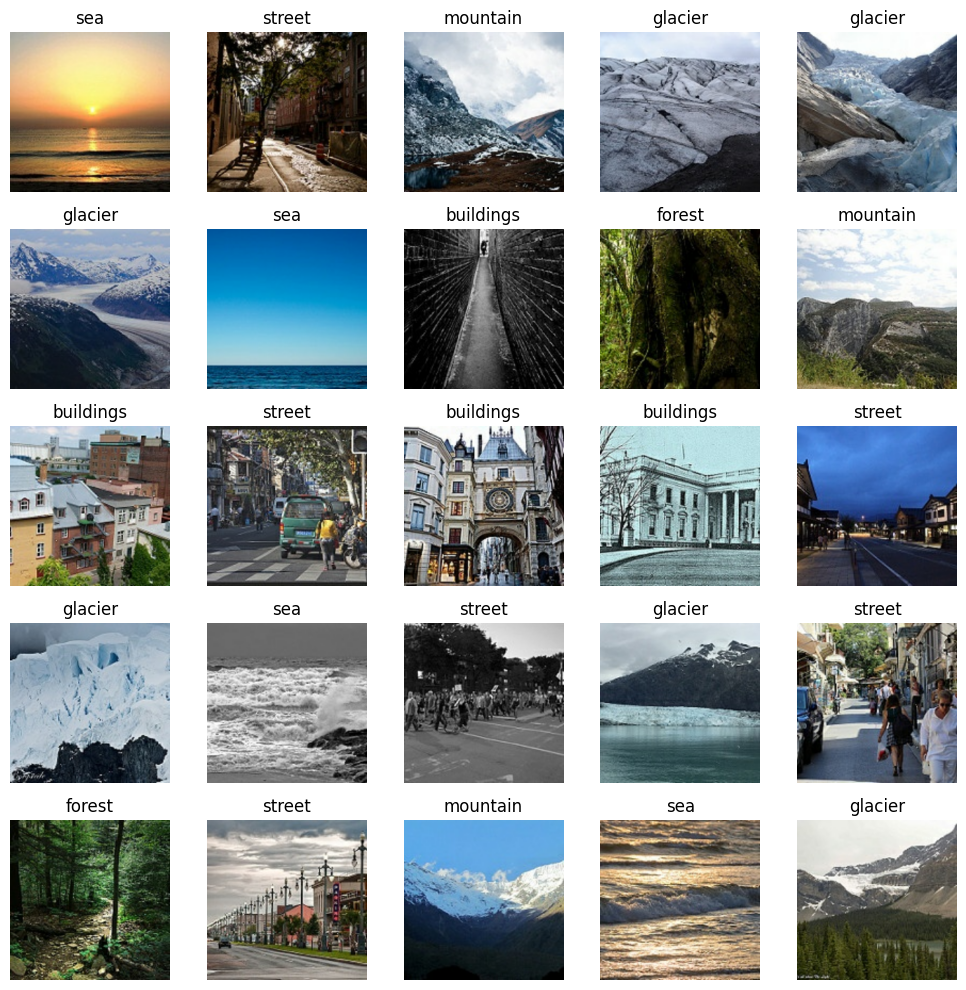

In [8]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Define paths 
trainpath = 'D:/7.10.2024/archive (28)/seg_train/seg_train'

# Load the training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    trainpath,
    seed=123,
    image_size=(228, 228),
    batch_size=32
)

# Retrieve class names from the dataset
class_names = train_ds.class_names
print("Class Names:", class_names)  # Print class names for verification

def display_sample_images(dataset, class_names, num_images=25, img_size=(10, 10)):
    """
    Display a grid of sample images from the dataset.

    Args:
        dataset (tf.data.Dataset): The dataset containing images and labels.
        class_names (list): List of class names corresponding to labels.
        num_images (int): Number of images to display in a grid.
        img_size (tuple): Size of the figure for display.
    """
    plt.figure(figsize=img_size)  # Set the figure size

    # Take a batch of images and labels from the dataset
    for images, labels in dataset.take(1):
        # Loop through the specified number of images
        for i in range(num_images):
            ax = plt.subplot(5, 5, i + 1)  # Create a subplot for each image
            plt.imshow(images[i].numpy().astype("uint8"))  # Display the image
            
            # Set the title using the label's corresponding class name
            plt.title(class_names[int(labels[i].numpy())], fontsize=12)  # Set the title with font size
            plt.axis("off")  

    plt.tight_layout()  
    plt.show()  

# Call the function to display sample images from the training dataset
display_sample_images(train_ds, class_names)


# Visualize Sample Testing Images

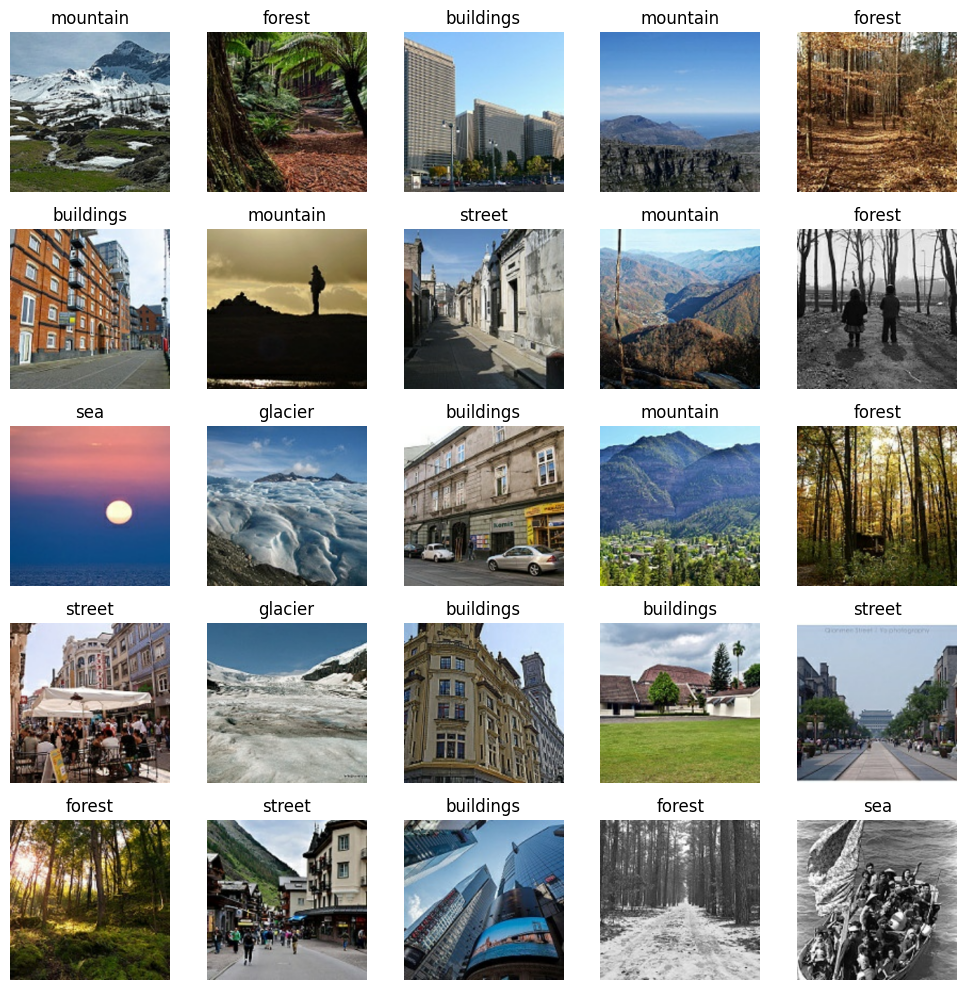

In [9]:
import matplotlib.pyplot as plt

def display_sample_images(dataset, class_names, num_images=25, img_size=(10, 10)):
    """
    Display a grid of sample images from the dataset.

    Args:
        dataset (tf.data.Dataset): The dataset containing images and labels.
        class_names (list): List of class names corresponding to labels.
        num_images (int): Number of images to display in a grid.
        img_size (tuple): Size of the figure for display.
    """
    plt.figure(figsize=img_size) 

    # Take a batch of images and labels from the dataset
    for images, labels in dataset.take(1):
        # Loop through the specified number of images
        for i in range(num_images):
            ax = plt.subplot(5, 5, i + 1)  # Create a subplot for each image
            plt.imshow(images[i].numpy().astype("uint8"))  # Display the image
            plt.title(class_names[int(labels[i].numpy())], fontsize=12)  # Set the title
            plt.axis("off") 

    plt.tight_layout()  
    plt.show()  

# Call the function to display sample images from the test dataset
display_sample_images(test_ds, class_names)


# Define and Build CNN Model

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Initialize the Sequential model
model = models.Sequential()

# Add convolutional and pooling layers
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(228, 228, 3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Flatten the output before the dense layers
model.add(layers.Flatten())

# Fully connected layers with dropout for regularization
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))

# Output layer with softmax activation for multi-class classification
model.add(layers.Dense(len(class_names), activation='softmax'))


In [11]:
# Display model summary for verification
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 226, 226, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 113, 113, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 111, 111, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 55, 55, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 53, 53, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 64)        0

# Compile the Model

In [12]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),  
    metrics=["accuracy"]
)

In [13]:
# Define the ModelCheckpoint callback
checkpointer = ModelCheckpoint(
    filepath='bestvalue.keras', 
    save_best_only=True, 
    verbose=1
)

# Define Callbacks for Early Stopping and Model Checkpointing

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define EarlyStopping callback
earlystopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    mode='min'
)

# Define ModelCheckpoint callback with HDF5 format
checkpointer = ModelCheckpoint(
    filepath='bestvalue.h5',  # Save the best model in .h5 format
    verbose=0,
    save_best_only=True,
    save_format='h5'  # Ensure model is saved in HDF5 format
)

# Create a list of callbacks
callback_list = [checkpointer, earlystopping]

# Fit the model with early stopping and checkpoint callbacks
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=40,
    callbacks=callback_list
)


Epoch 1/40
439/439 [==============================] - 198s 449ms/step - loss: 1.2111 - accuracy: 0.5546 - val_loss: 0.8201 - val_accuracy: 0.6923
Epoch 2/40


C:\Users\ARPAN\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


439/439 [==============================] - 202s 460ms/step - loss: 0.8110 - accuracy: 0.6961 - val_loss: 0.6982 - val_accuracy: 0.7443
Epoch 3/40
439/439 [==============================] - 206s 469ms/step - loss: 0.7024 - accuracy: 0.7459 - val_loss: 0.6096 - val_accuracy: 0.7893
Epoch 4/40
439/439 [==============================] - 210s 477ms/step - loss: 0.6238 - accuracy: 0.7750 - val_loss: 0.5509 - val_accuracy: 0.8067
Epoch 5/40
439/439 [==============================] - 211s 480ms/step - loss: 0.5254 - accuracy: 0.8090 - val_loss: 0.5273 - val_accuracy: 0.8217
Epoch 6/40
439/439 [==============================] - 207s 471ms/step - loss: 0.4723 - accuracy: 0.8274 - val_loss: 0.6736 - val_accuracy: 0.7837
Epoch 7/40
439/439 [==============================] - 212s 484ms/step - loss: 0.4363 - accuracy: 0.8434 - val_loss: 0.5390 - val_accuracy: 0.8267
Epoch 8/40
439/439 [==============================] - 213s 485ms/step - loss: 0.3909 - accuracy: 0.8588 - val_loss: 0.6419 - val_accura

# Plot Training and Validation Loss

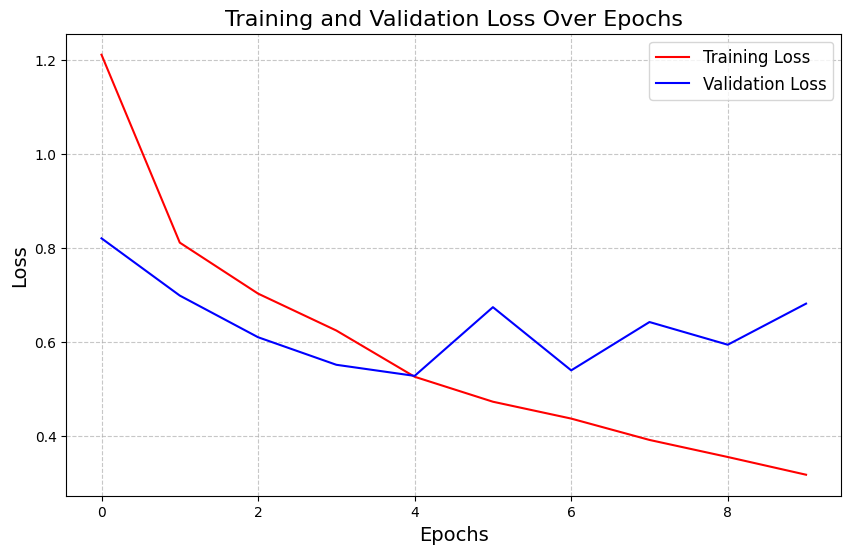

In [15]:
# Extract loss values
loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a range for the epochs
epochs = range(len(loss))

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot training and validation loss
plt.plot(epochs, loss, color="red", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", label="Validation Loss")

# Add labels and title
plt.title("Training and Validation Loss Over Epochs", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)

# Add gridlines for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Add a legend
plt.legend(fontsize=12)

# Show the plot
plt.show()


# Plot Training and Validation Accuracy

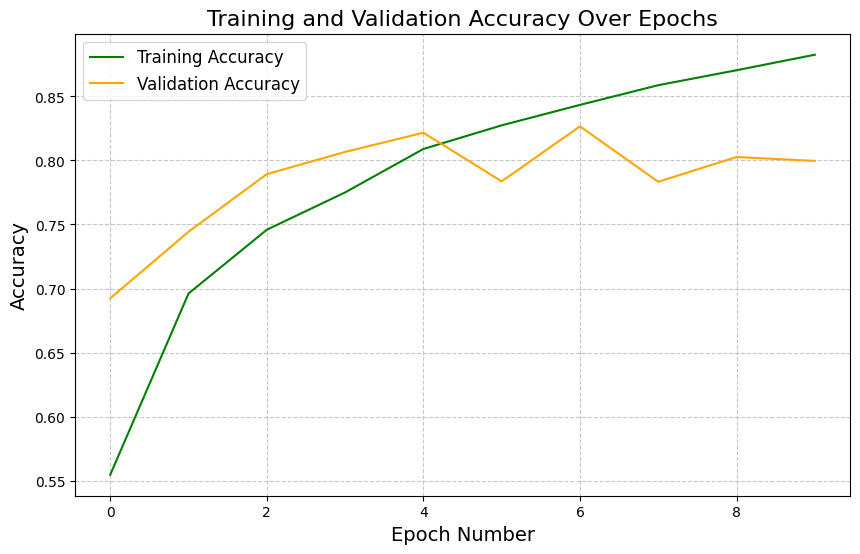

In [16]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')

# Add labels and title
plt.title('Training and Validation Accuracy Over Epochs', fontsize=16)
plt.xlabel('Epoch Number', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)

# Add gridlines for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Add a legend
plt.legend(fontsize=12)

# Show the plot
plt.show()
